# **Chap 7：自然语言处理**

In [1]:
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import time
from source.code import ch7
from source.code import utils 

2023-05-31 11:09:06.271779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 11:09:06.458791: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-31 11:09:06.491476: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-31 11:09:07.619773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **7.1 词嵌入 word2vec**

### **7.1.1 自监督的词向量表示 word2vec**

**(1) 词向量表示的背景**

在 `RNN` 部分的学习过程中，我们介绍了部分自然语言处理的相关知识，现在我们将进一步深入讨论

对文本这种序列进行建模时，我们通常需要先将文本按照某种规则**进行分词**（`tokenize`），然后**创建词表**（`Vocab`），词表负责将分词后的每个字符串映射到一个**整数索引**，但在输入给模型之前，我们不会直接使用整数索引，因为**索引变换范围很大**（`[0, vocab_size]`），这会带来极大的**数值不稳定性**

一种处理这种离散编码的方案是**One Hot编码**（虽然我们在 `RNN` 一节中没有使用），它将索引为 $i$ 的变量编码到一个长度为 `vocab_size` 的 **01 二值向量**，使其第 $i$ 个分量为 1，其余分量为 0
* 独热编码虽然思想简单，操作容易，但通常并不是一个合适的选择
* 一方面，它会带来**稀疏矩阵**的问题，浪费不必要的内存空间
* 另一方面，词元的独热编码表示依然没办法满足**相近含义的词应该有相近的词向量表示**的要求

例如考虑两个词向量 $x,y\in\mathbb{R}^{p}$，计算它们的**余弦相似度**：
$$
\frac{x^Ty}{\|x\| \|y\|} \in [-1,1]
$$

我们希望含义相近的词具有越高的预先相似度，但**对于独热编码而言，任意两个词的余弦相似度都等于 0**

**(2) word2vec 模型**

因此，人们提出**嵌入层**（`Embedding Layer`）的概念，嵌入层负责将每个词元映射到一个固定维度 $p$ 的**稠密向量**，并希望该稠密向量空间能够正确表示词元的含义，`word2vec` 就是词嵌入重要的工作之一，word2vec 包含两种不同的建模思路：**跳元模型**（**Skip-Gram**），和**连续词袋**（**CBOW**）
* 这两种模型都从语义的角度对文本序列建模，训练依赖于条件概率（即用文本序列中的一些词去预测另一些词）
* 由于这些文本序列建模过程中，**不需要额外标注的标签信息**，文本序列建模的一大特点是可以从文本自身出发构造出标签，因此这类模型称为**自监督模型**

#### **跳元模型 Skip-Gram**

跳元模型假设**一个词可以用来在文本序列中生成其周围的词**，假设词元序列为 $x_1,x_2,\cdots,x_T$，中心词是 $x_k$，并**将上下文窗口大小设置为** $2$，则建模考虑的条件概率为：
$$
P(x_{k-2},x_{k-1},x_{k+1},x_{k+2}|x_k)
$$

如果**假设上下文词在给定中心词时是独立生成的**，则条件概率由独立性假设会变得更加简单：
$$
P(x_{k-2}|x_k)\cdot P(x_{k-1}|x_k)\cdot P(x_{k+1}|x_k)\cdot P(x_{k+2}|x_k)
$$

在跳元模型中，每个词元 $x_i$ 会**有两个维度为 $p$ 的词向量表示** $v_i,u_i\in\mathbb{R}^p$，它们分别作为**中心词表示**和**上下文表示**：
* 当把 $x_i$ **作为中心词使用时**，它将用 $v_i$ 来表示其嵌入结果
* 而如果 $x_i$ 被**作为上下文词使用时**，它将用 $u_i$ 来表示其嵌入结果

因此，当给定中心词 $w_c$（假设在词表中的索引为 $c$），其生成任何上下文词元 $w_o$（假设在词表中的索引为 $o$）的**条件概率被建模为**：
$$
P(w_o|w_c) = \frac{ \exp(u_o^Tv_c) }{ \sum_{i\in\mathcal{V}} \exp(u_i^Tv_c) }
$$

其中，$\mathcal{V}$ 是词表中词元索引集合，当给定一个长度为 $T$ 的文本序列，$w_t$ 表示时间步 $t$ 处的词元，并**继续使用条件概率的独立性假设**，则对于上下文窗口 $m$，该序列的**跳元模型的似然概率可以写作**：
$$
\prod_{t=1}^{T} \prod_{\substack{-m\leq j\leq m,j\ne 0\\ 1\leq t+j \leq T}} P(w_{t+j} | w_t)
$$

在建模时，可以省略所有时间步小于 $1$ 和大于 $T$ 的概率，训练时，**中心词向量和上下文词向量** $v_i,u_i$ **作为模型参数进行更新**，通过**最大化似然函数**或者**最小化下方的对数似然函数**来驱动模型训练，它就是模型的**损失函数** $L$：
$$
L = -\sum_{t=1}^{T} \sum_{-m\leq j\leq m,j\ne 0} \log P(w_{t+j}|w_t)
$$

训练结束后，我们得到每个词元 $x_i$ 的中心词表示 $v_i\in\mathbb{R}^p$，和上下文词表示 $u_i\in\mathbb{R}^p$，**在自然语言处理应用中，跳元模型的中心词向量通常用作词嵌入的表示**

#### **连续词袋模型 CBOW**

连续词袋模型类似于跳元模型，只不过**将建模方向调换一下**，我们**用上下文词元来预测中心词元**，同样给定序列 $x_1,x_2,\cdots,x_T$，中心词是 $x_k$，并将**上下文窗口长度设置为 2**，则建模考虑的条件概率为：
$$
P(x_k|x_{k-2},x_{k-1},x_{k+1},x_{k+2})
$$

由于 CBOW 模型中存在多个上下文词元，因此在计算条件概率时需要**对这些上下文词向量进行平均**，我们用 $v_i,u_i\in\mathbb{R}^p$ 是**词元的上下文词向量表示和中心词向量表示**（**注意，这里与跳元模型中的符号相反**），给定上下文序列 $w_{o_1},\cdots,w_{o_{2m}}$，下标表示词元索引，它们生成中心词 $w_c$，则条件概率为：
$$
P(w_c | w_{o_1},\cdots,w_{o_{2m}}) = \frac{ \exp{\left( \frac{1}{2m} u_c^T(v_{o_1} + \cdots + v_{o_{2m}}) \right)} }{ \sum_{i\in\mathbb{V}} \exp{\left( \frac{1}{2m} u_i^T(v_{o_1} + \cdots + v_{o_{2m}}) \right)}  }
$$

我们记 $W_o = \{w_{o_1},\cdots,w_{o_{2m}}\}$，以及上下文的均值向量 $\overline{v}_o = (v_{o_1} + \cdots + v_{o_{2m}}) / (2m)$，则上式可以简化：
$$
P(w_c | W_o) = \frac{ \exp(u_c^T \overline{v}_o) }{ \sum_{i\in\mathbb{V} } \exp(u_i^T \overline{v}_o) }
$$

当给定一个长度为 $T$ 的文本序列，则对于上下文窗口 $m$，该序列的**连续词袋模型的似然概率可以写作**：
$$
\prod_{t=1}^{T} P(w_t | w_{t-m},\cdots,w_{t-1},w_{t+1},\cdots,w_{t+m})
$$

在训练模型参数 $v_i,u_i$ 时，依然是通过**最小化负对数似然进行的**：
$$
L = -\sum_{t=1}^T \log P(w_t|w_{t-m},\cdots,w_{t-1},w_{t+1},\cdots,w_{t+m})
$$

训练结束后，我们得到每个词元 $x_i$ 的上下文表示 $v_i\in\mathbb{R}^p$，和中心词表示 $u_i\in\mathbb{R}^p$，**与跳元模型不同，CBOW 的上下文词向量用作词嵌入的表示**

### **7.1.2 word2vec 模型预训练**

由于跳元模型和连续词袋模型的相似性，后文中，我们仅以跳元模型为例进行说明

**(1) 近似训练**

无论是跳元模型还是连续词袋模型，在实际应用中，词表大小 $|\mathcal{V}|$ 可能达到几十万，概率建模中包含的 `softmax` 操作都需要计算 $|\mathcal{V}|$ 个求和项，再考虑到模型更新时梯度下降，**求和的梯度计算成本巨大**，为了降低计算复杂度，两种主流的处理思路是**负采样**和**分层 softmax**
* **负采样**
  * 定义**事件** $S$：给定中心词 $w_c$ 和上下文窗口，任何上下文词 $w_o$ 来自该上下文窗口，该事件的概率用下式建模：
    $$
    P(D=1|w_c,w_o) = \sigma(u_o^Tv_c)
    $$
    $\sigma$ 是 `sigmoid` 函数，将内积映射为概率
  * 考虑从**最大化序列中所有上述事件的联合概率**的角度出发，则目标变为最大化下面的概率模型：
    $$
    \prod_{t=1}^{T}\prod_{-m\leq j\leq m,j\ne 0} P(D=1|w_t,t_{t+j})
    $$
    但上式只考虑了**正样本事件**（上述概率仅当所有词向量趋于无穷时，概率取得最大值 1，这**显然毫无意义**），因此，为了使目标函数变得有意义，**负采样技术**从预定义的分布中采样负样本，并添加到概率模型中
  * 从预定义的分布 $P(w)$ 中采样 $K$ 与事件 $S$ 相悖的**噪声词**，并用 $N_k$ 表示噪声词 $w_k,k=1,\cdots,K$ 不是来自 $w_c$ 的上下文窗口的事件，假设正样本和负样本 $S,N_1,\cdots,N_K$ **事件相互独立**，则负采样会将上述仅涉及正样本的联合概率改写为：
    $$
    \prod_{t=1}^{T}\prod_{-m\leq j\leq m,j\ne 0} P(w_{t+j} | w_t)
    $$ 
    通过事件 $S,N_1,\cdots,N_K$ 的**近似条件概率** 对 $P(w_{t+j}| w_t)$ 建模：
    $$
    P(w_{t+j}|w_t) = P(D=1| w_t,w_{t+j}) \prod_{k=1, w_k\sim P(w)}^{K} P(D=0|w_t,w_k)
    $$
    其中，概率 $P(D=0|w_t,w_k) = 1 - P(D=1|w_t,w_k)$
  * 现在经过转换，每个训练步中，模型推理，梯度计算的成本都与词表大小 $|\mathcal{V}|$ 无关了，而是**线性依赖于负采样个数** $K$，当将超参数 $K$ 设置为较小的数时，负采样每个训练步的梯度计算成本较小

* **分层 softmax / 层序 softmax**
  * 虽然分层 softmax 名字中依然包含 softmax，但实际的计算过程与 softmax 没有关系，算法的第一步，需要**根据每个词元的词频，创建一棵 Huffman 二叉树**，**越靠近树根，词元词频越高**，最终，**每个词元会被编码到二叉树的某个叶子结点上**（具体可以查阅 [Huffman二叉树](https://blog.csdn.net/qq_46785243/article/details/127622507)）
  * 假设下图是我们根据词频得到的一棵二叉树的部分结构：
  
    <img src="./source/Chap7/Huffman二叉树.svg" width=600>
  
    此外，对于每个非叶子节点，它们还需要存储一个**隐藏的可训练参数** $\theta\in\mathbb{R}^p$，它与词元嵌入的表示 $v_i$ 具有相同的维度
  * 用 $L(w)$ 表示二叉树中词元 $w$ 所在的叶节点深度，例如 $L(w_3) = 4$，设 $n(w,j)$ 表示到达词元 $w$ 的路径上的第 $j$ 个节点，其保存的参数为 $\theta_{n(w,j)}$，则**条件概率被建模为**：
    $$
    P(w_o | w_c) = \prod_{j=1}^{L(w_o) - 1} \sigma\left( \text{isLeft}(n(w_o,j),n(w_o,j+1))\cdot \theta_{n(w_o,j)}^T v_c \right)
    $$
    其中，$\sigma$ 是 `sigmoid` 函数，$\text{isLeft}$ 函数判断路径中下一个节点 $n(w_o,j+1)$ 是否是 $n(w_o,j)$ 的左子节点，**是取 1，否取 -1**
  * 对于给定中心词 $w_c$，向上图中生成 $w_3$ 的条件概率可以写作：
    $$
    P(w_3 | w_c) = \sigma(u_{n(w_3,1)}^Tv_c)\cdot \sigma(-u_{n(w_3,2)}^Tv_c)\cdot \sigma(u_{n(w_3,3)}^Tv_c)
    $$
  * 由于 $\sigma(x) + \sigma(-x) = 1$，基于中心词 $w_c$ 生成词表中所有可能的词的条件概率和等于 1，这相当于遍历了整棵二叉树：
    $$
    \sum_{i \in\mathcal{V}} P(w_i | w_c) = 1
    $$
  * 通过这种二叉树的技巧，**树的深度大约为** $\mathcal{O}(\log_2 |\mathcal{V}|)$，因此，当词表大小很大时，**使用分层 softmax 这种近似算法也能使得计算复杂度大大降低**

**(2) 预训练数据集**

**(2.1) 导入数据，创建词表**

我们演示使用 `PTB`（`Penn Tree Bank`，华尔街日报文章数据集）数据集来**预训练一个 word2vec 模型**
* 在深度学习中，**预训练**（**Pre-Training**）希望让模型在一些较为通用的数据集上训练以**获得通用的特征抽取能力**
  * 例如在 CNN 中，在 `ImageNet` 预训练过的 ResNet，VGGNet 等模型就有很好的泛化能力，我们只需要**借助它们，根据下游任务进行微调**
  * word2vec 可以作为文本处理方面的预训练模型，它可以用于抽取词元的特征
* `PTB` 语料库分为训练集、验证集和测试集，文本文件的每一行表示由空格分隔的一句话
* 在该任务中，我们**以每个单词作为一个词元**

In [3]:
def load_ptb(path : str):
    with open(path, 'r') as f:
        lines = f.read()
    # 按照换行符分割，抽取得到每个句子
    # 然后按照空格分割，得到每个单词，完成分词
    # 由于 PTB 数据集非常干净，所以不需要做其他的预处理
    return [sentence.split() for sentence in lines.split('\n')]

In [4]:
sentences = load_ptb(path="./source/data/text/ptb/ptb.train.txt")
print("句子数目：", len(sentences))

句子数目： 42069


与所有自然语言处理任务相同，我们需要创建词表 `Vocab`，设置 `min_freq = 10` 过滤掉出现次数较少的词元

In [5]:
vocab = utils.Vocab(sentences, min_freq=10)
print("词表大小：", len(vocab))

词表大小： 6722


**(2.2) 下采样**

一些上下文连接词，例如 `the`, `a`, `in` 等，**在文本中出现的频率非常高**（在大型文本数据集中，出现次数可能超过几十亿次）
* 但这些词在上下文窗口中通常与其他有意义的词元一同出现，**提供的信息又很少**，无含义的高频词可能会**让模型对概率的建模偏向于选择预测这些无意义的词**
* 此外，这些无含义的高频词，会**占用很多的计算时间，使得模型的训练速度变慢**

一种解决思路是，对文本中出现的高频词进行**下采样**，舍数据集中每个词 $w_i$ 的次数与总词数的比例为 $f(w_i)$，则**下采样按照概率** $P(w_i)$ **丢弃词元**：
$$
P(w_i) = \max\left( 1 - \sqrt{\frac{t}{f(w_i)}},0 \right)
$$
常数 $t$ 是超参数，例如取 $t = 10^{-4}$，只有当 $f(w_i) > t$ 时，高频词 $w_i$ 才能被丢弃，并且**出现频率** $f(w_i)$ **越高，被丢弃的概率越大**

函数 `down_sampling()` 用于实现对高频词的下采样，函数已经写入 `/source/code/ch7.py`

In [6]:
def down_sampling(sentences : list, vocab, t : float = 1e-4):
    from collections import Counter
    import random
    # 下采样高频词

    # 排除掉未知词元 <unk>
    sentences = [[token for token in line if vocab[token] != vocab['<unk>']] for line in sentences]
    
    # 统计词频
    
    counter = Counter([token for line in sentences for token in line])
    num_tokens = sum(counter.values()) # 总词数

    # 定义一个辅助函数，如果在下采样过程中保留该词，则返回 True
    def keep(token):
        return random.uniform(0, 1) < np.sqrt(t / counter[token] * num_tokens)
    
    # 对每个句子的词元进行下采样
    return [[token for token in line if keep(token)] for line in sentences], counter

In [7]:
# 对高频词进行下采样
down_sampled_sentences, counter = down_sampling(sentences, vocab)

绘制下采样前后，句子长度的分布可以看到，**下采样通过删除高频词能够显著缩短句子，从而加速模型的训练**

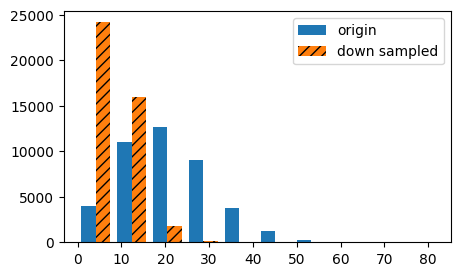

In [8]:
fig = plt.figure(figsize=(5, 3))
# 统计句子长度
origin = [len(line) for line in sentences]
down_sampled = [len(line) for line in down_sampled_sentences]
# 绘制直方图
_,_,patches = plt.hist([origin, down_sampled], bins=10, label=["origin", "down sampled"])
# 显示条纹
for patch in patches[1]:
    patch.set_hatch('///')
plt.legend()

函数 `compare_token_counts` 帮助我们对比下采样前后，词元出现频率的变化情况
* 高频词元被大幅下采样，而低频词元不受影响，继续保留

In [9]:
def compare_token_counts(token):
    print("词元 {} 的数量：\n下采样前：{}\n下采样后：{}".format(token, 
        sum([line.count(token) for line in sentences]), 
        sum([line.count(token) for line in down_sampled_sentences])))

In [10]:
compare_token_counts("the")
compare_token_counts("join")

词元 the 的数量：
下采样前：50770
下采样后：2055
词元 join 的数量：
下采样前：45
下采样后：45


现在，我们可以将词元映射到词表索引，处理为语料 `corpus`

In [12]:
corpus = [vocab[line] for line in down_sampled_sentences]
print("语料大小：", len(corpus))
print("第10个句子：", corpus[9])

语料大小： 42069
第10个句子： [66, 278, 1902, 1442, 2370, 3145, 716, 108, 5582, 1295]


**(3) 抽取中心词和上下文**

函数 `create_centers_and_context` 用于构造中心词和上下文：
* 我们依次处理每条语句，并把每条语句的每个词元都作为中心词
* 生成中心词对应的上下文时，我们随机从范围 `[1, max_window_size]` 选取窗口长度，然后**从中心词两侧扩散**，得到上下文窗口
  * 需要**确保窗口范围不会小于 0，也不会大于句子长度**
  * 为了确保至少有一个上下文词，句子的长度必须大于 2

In [13]:
def create_centers_and_context(corpus : list, max_window_size : int=2):
    # 抽取中心词和上下文词
    import random

    # 初始化中心词和上下文词
    centers, contexts = [], []
    # 遍历每个句子
    for line in corpus:
        # 如果句子长度小于 2，跳过
        if len(line) < 2:
            continue
        # 遍历句子中的每个词元，将其作为中心词
        centers += line # 先将句子中的词元添加到中心词列表中
        for index, center in enumerate(line):
            # 随机选择窗口大小
            window_size = random.randint(1, max_window_size)
            # 确认上下文词的索引
            indices = list(range(max(0, index - window_size), min(len(line), index + 1 + window_size)))
            indices.remove(index) # 移除中心词
            contexts.append([line[idx] for idx in indices]) # 添加上下文词
    return centers, contexts

我们可以创建一个测试语料库，观察中心词和上下文词的抽取逻辑

In [14]:
fake_corpus = [list(range(5)), list(range(7, 10))]
print("语料：", fake_corpus)
centers, contexts = create_centers_and_context(fake_corpus, max_window_size=2)
for center, context in zip(centers, contexts):
    print("中心词", center, "的上下文词是：", context)

语料： [[0, 1, 2, 3, 4], [7, 8, 9]]
中心词 0 的上下文词是： [1, 2]
中心词 1 的上下文词是： [0, 2, 3]
中心词 2 的上下文词是： [0, 1, 3, 4]
中心词 3 的上下文词是： [2, 4]
中心词 4 的上下文词是： [3]
中心词 7 的上下文词是： [8]
中心词 8 的上下文词是： [7, 9]
中心词 9 的上下文词是： [7, 8]


对于 `PTB` 数据集，我们可以设置最大窗口长度为 `max_window_size = 5`

In [15]:
centers, contexts = create_centers_and_context(corpus, max_window_size=5)
print("中心词-上下文词对数目：", len(centers))

中心词-上下文词对数目： 342754


**(4) 负采样**

我们来实现在**近似训练**中提到的**负采样技巧**
* 创建 `RandomGenerator` 类根据采样权重 `sampling_weights`在顺序索引中采样

In [16]:
class RandomGenerator:
    def __init__(self, sampling_weights, buffer_size : int=10000) -> None:
        self.population = list(range(len(sampling_weights))) # 总体的顺序索引
        self.samping_weights = sampling_weights
        self.candidates = []
        self.i = 0
        self.buffer_size = buffer_size # 缓存大小
    
    # 采样
    def draw(self):
        import random
        # 通过递归，直到采样数目达到 
        if self.i == len(self.candidates):
            # 缓存采样结果
            self.candidates = random.choices(self.population, weights=self.samping_weights, k=self.buffer_size)
            self.i = 0 # 重置索引
        # 每次返回一个采样结果，并将索引加 1
        self.i += 1
        return self.candidates[self.i - 1]

例如我们有三个索引 `[0,1,2]`，如下方式可以得到一个采样比例为 `2 : 3 : 4` 的抽样结果

In [17]:
generator = ch7.RandomGenerator([1, 3, 5])
[generator.draw() for _ in range(20)] # 采样 20 次

[0, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1]

`negative_sampling()` 用于实现负采样，负采样的个数 `K` 作为超参数可以控制
* 采样分布 $P(w)$ 根据 word2vec 原论文中的建议，可以**设置为词元出现频率的 0.75 次幂**

In [18]:
def negative_sampling(contexts, vocab, counter, K : int=5):
    """
    ## negative_sampling
        上下文词元负采样

    Parameters
    ----------
    contexts : list
        上下文词元列表
    vocab : Vocab
        词表
    counter : dict
        词频统计
    K : int, default = 5
        负采样数目
    """
    
    # 计算采样权重，确定采样分布 P(w)
    # 四个特殊词元不会出现在词频统计中，因此使用 get 方法获取词频时，指定默认值 0
    # 0**0.75 = 0，因此这四个特殊词元的采样权重为 0
    sampling_weights = [counter.get(vocab.to_tokens(i),0)**0.75 for i in range(len(vocab))]
    # 初始化采样器和负样本
    sampler = ch7.RandomGenerator(sampling_weights)
    negatives = []
    # 遍历每个上下文词元
    for context in contexts:
        negative = [] # 初始化当前上下文词元的负样本
        while len(negative) < len(context) * K: # 每个上下文词元需要采样 K 个负样本
            # 采样
            neg = sampler.draw()
            # 如果采样到的词元是上下文词元，跳过
            if neg not in context:
                negative.append(neg)
        negatives.append(negative)

    return negatives

In [19]:
negative_samples = negative_sampling(contexts, vocab, counter, K=5)

**(5) 组件整合，拼装为批量数据**

`create_batch_data()` 用于创建和组装批量数据，我们需要将中心词，上下文词（正样本）和随机采样的噪声词（负样本）填充到相同的维度拼在一起
* 输入 `data` 是一个列表，长度等于样本量，**每个元素包含三个部分**：中心词，上下文词和噪声词
* 在批量中，第 $i$ 个样本的中心词，可能有 $n_i$ 个上下文词和 $m_i$ 个噪声词，由于**上下文窗口不固定**，$n_i + m_i$ 也各不相同
  * 我们用 `context_negatives` 将上下文和噪声词连接起来，并**通过填充 0 使其扩充到固定长度** `max_len = max_i(n_i + m_i)`
  * 在计算损失时，我们类似之前 RNN 和 Transformer，**创建掩码** `masks`，将填充的元素掩蔽，从而**在损失的计算中过滤掉它们**
  * 同理，为了区分正样本和负样本，我们也创建一个掩码 `labels`，当 `labels = 1` 时，其对应上下文词，即正样本
  * `masks` 和 `labels` 与 `context_negatives` 有相同的形状，它们的元素一一对应

In [20]:
def create_batch_data(data : list):
    # 计算 max_len
    max_len = max([len(context) + len(negative) for center, context, negative in data])
    # 初始化中心词、上下文词和负样本的索引列表，以及掩码
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        valid_len = len(context) + len(negative) # 当前样本的有效长度
        centers += [center] # 添加中心词
        contexts_negatives += [context + negative + [0] * (max_len - valid_len)] # 添加上下文词和负样本
        masks += [[1] * valid_len + [0] * (max_len - valid_len)] # 有效填充的掩码
        labels += [[1] * len(context) + [0] * (max_len - len(context))] # 正负样本掩码
    return tf.reshape(tf.constant(centers), (-1,1)), tf.constant(contexts_negatives), tf.constant(masks), tf.constant(labels)

In [22]:
x1 = (1, [2, 2], [3, 3, 3, 3])
x2 = (1, [2, 2, 2], [3, 3])
batch = ch7.create_batch_data((x1, x2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tf.Tensor(
[[1]
 [1]], shape=(2, 1), dtype=int32)
contexts_negatives = tf.Tensor(
[[2 2 3 3 3 3]
 [2 2 2 3 3 0]], shape=(2, 6), dtype=int32)
masks = tf.Tensor(
[[1 1 1 1 1 1]
 [1 1 1 1 1 0]], shape=(2, 6), dtype=int32)
labels = tf.Tensor(
[[1 1 0 0 0 0]
 [1 1 1 0 0 0]], shape=(2, 6), dtype=int32)


最后，我们将以上所有组件包装成为 `create_PTBdataloader()`

In [54]:
def create_PTBdataloader(path : str, batch_size : int=32, max_window_size : int=5, num_noise_words : int=5):
    # 加载文件，并进行分词
    sentences = load_ptb(path)
    vocab = utils.Vocab(sentences, min_freq=10) # 创建词表
    # 下采样高频词元
    down_sampled, counter = ch7.down_sampling(sentences,vocab)
    corpus = [vocab[line] for line in down_sampled] # 将词元转换为索引
    centers, contexts = ch7.create_centers_and_context(corpus, max_window_size) # 创建中心词和上下文词
    negatives = ch7.negative_sampling(contexts, vocab, counter, num_noise_words) # 创建负样本

    # 数据集 PTB 的 DataLoader
    class PTBDataset:
        def __init__(self, centers, contexts, negatives) -> None:
            assert len(centers) == len(contexts) == len(negatives) # 确保三个列表长度相同
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
            self.data = list(zip(self.centers, self.contexts, self.negatives)) # 将三个列表打包为列表
        
        # 每次返回一份批量数据
        def __iter__(self):
            # 打乱数据
            import random
            random.shuffle(self.data)
            # 根据 batch_size 划分数据
            for i in range(0, len(self.data), batch_size):
                yield create_batch_data(self.data[i:i+batch_size])

        def __len__(self):
            return len(self.centers)

        def create_dataset(self):
            dataset = tf.data.Dataset.from_generator(self.__iter__, output_types=(tf.int32,tf.int32,tf.int32,tf.int32))
            return dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    dataset = PTBDataset(centers, contexts, negatives)
    return dataset.create_dataset(), vocab

In [55]:
data_iter, vocab = ch7.create_PTBdataloader(
    path='./source/data/text/ptb/ptb.train.txt', batch_size=32, max_window_size=5, num_noise_words=5)

可以观察到，每个批量数据的样本量都为 `batch_size`，但是**不同批量的** `contexts_negatives` **长度可能会不一样**

In [56]:
batch_cnts = 0
for batch in data_iter:
    batch_cnts += 1
    for name, data in zip(names, batch):
        print(name, 'shape: ', data.shape)
    print()
    if batch_cnts >= 3:
        break

centers shape:  (32, 1)
contexts_negatives shape:  (32, 54)
masks shape:  (32, 54)
labels shape:  (32, 54)

centers shape:  (32, 1)
contexts_negatives shape:  (32, 60)
masks shape:  (32, 60)
labels shape:  (32, 60)

centers shape:  (32, 1)
contexts_negatives shape:  (32, 60)
masks shape:  (32, 60)
labels shape:  (32, 60)



**(3) 模型训练**

接下来，我们定义 word2vec 模型及其计算逻辑，然后训练模型，我们仅以跳元模型为例进行说明

首先，我们需要一个 `Embedding` 层将词元整数索引映射到给定维度 `embed_size` 的词向量空间

In [65]:
# input_dim 为词表大小 vocab_size，output_dim 为词向量维度
embed = tf.keras.layers.Embedding(input_dim=20, output_dim=4)
x = tf.constant([[0,1,2],[1,2,3]])
embed(x)

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 0.00821521,  0.00616704,  0.03815914,  0.01318972],
        [-0.02145312,  0.04401647,  0.04825136,  0.04198031],
        [ 0.02694089, -0.0177655 ,  0.04446788, -0.02161142]],

       [[-0.02145312,  0.04401647,  0.04825136,  0.04198031],
        [ 0.02694089, -0.0177655 ,  0.04446788, -0.02161142],
        [ 0.03820852, -0.01937146,  0.04628712,  0.03335824]]],
      dtype=float32)>

接下来，定义**跳元模型的前向推理过程**：
* `skip_gram()` 的输入参数包含中心词 `centers`，上下文词与噪声词的拼接 `contexts_negatives`
* 我们还向函数传递了负责词元**中心词表示和上下文表示的两个嵌入层** `embed_v, embed_u`

In [66]:
def skip_gram(centers, contexts_negatives, embed_v, embed_u):
    # centers 形状：(batch_size, 1)
    # contexts_negatives 形状：(batch_size, max_len)
    
    v = embed_v(centers) # 中心词的词向量表示，形状：(batch_size, 1, embed_size)
    u = embed_u(contexts_negatives) # 上下文词和负样本的词向量表示，形状：(batch_size, max_len, embed_size)
    # 做批量矩阵乘法，得到中心词和上下文词的内积
    # 形状：(batch_size, 1, max_len)
    pred = tf.matmul(v, tf.transpose(u, perm=[0,2,1]))
    return pred

可以将它们简单的封装为模型 `word2vecSkipGram`

In [72]:
class word2vecSkipGram(tf.keras.Model):
    def __init__(self, vocab_size : int, embed_size : int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.embed_size = embed_size
        self.embed_v = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, name='embed_v')
        self.embed_u = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, name='embed_u')
    
    def call(self, centers : tf.Tensor, contexts_negatives : tf.Tensor, *args, **kwargs):
        return skip_gram(centers, contexts_negatives, embed_v=self.embed_v, embed_u=self.embed_u)

In [73]:
word2vec = word2vecSkipGram(vocab_size=len(vocab), embed_size=64)
for batch in data_iter:
    print("输出形状：",word2vec(batch[0], batch[1], training=False).shape)
    break

输出形状： (32, 1, 54)


我们为上下文和负采样得到的噪声词定义了掩码 `masks` 和 `labels`，因此**需要重新调整一下损失函数的计算**
* 我们的模型 `word2vec` 的输出 `preds` 没有进行概率变换，是原始的 logits 向量，**每个元素预测对应的上下文词是正样本还是负样本**（**二分类问题**）
* 假设 `preds` 的形状是 `(batch_size, max_len)`，则上述损失计算的形状也为 `(batch_size, max_len)`，**随后用相同形状的** `masks` **去除掉那些我们为了补全序列长度到** `max_len` **的无效词元的损失**

In [7]:
class SigmoidCELoss(tf.keras.losses.Loss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __call__(self, labels, preds, masks, *args, **kwargs):
        # labels, preds, masks 形状：(batch_size, max_len)
        masked_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=preds) * masks # 形状：(batch_size, max_len)
        loss = tf.reduce_sum(masked_loss, axis=1) # 形状：(batch_size,)
        return loss / tf.reduce_sum(masks, axis=1) # 形状：(batch_size,)

最后，我们定义模型的训练函数

In [14]:
def train_word2vec(model, data_iter, lr : float=0.01, Epochs : int=10, verbose : int=1):
    # 定义优化器和损失函数
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_func = SigmoidCELoss()

    # 展示训练进度
    animator = utils.Animator(xlabel='epoch', ylabel='loss', xlim=[1, Epochs])

    for epoch in range(Epochs):
        # 存储每个迭代周期的损失和样本量
        loss_batch = tf.constant(0.0)
        train_samples = tf.constant(0)

        for i, batch in enumerate(data_iter):
            centers, contexts_negatives, masks, labels = batch
            with tf.GradientTape() as tape:
                # preds 形状：(batch_size, 1, max_len)
                preds = model(centers, contexts_negatives, training=True)
                # 变换 preds 形状，去掉中间的维度，得到形状：(batch_size, max_len)
                preds = tf.squeeze(preds, axis=1)
                # 为了满足损失计算的要求，需要将 labels, masks 变为 tf.float32 类型
                loss = loss_func(tf.cast(labels, tf.float32), preds, tf.cast(masks, tf.float32))
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            optimizer.apply_gradients(zip(grads, weights))

            # 计算损失
            loss_batch += tf.reduce_sum(loss)
            train_samples += tf.reduce_sum(masks)

        if epoch == 0 or (epoch + 1) % verbose == 0:
            train_loss = loss_batch.numpy() / train_samples.numpy()
            animator.add(epoch + 1, (train_loss,))

    return model

导入数据集，然后训练 `word2vec` 模型

In [37]:
data_iter, vocab = ch7.create_PTBdataloader(
    path='./source/data/text/ptb/ptb.train.txt', batch_size=512, max_window_size=5, num_noise_words=5)

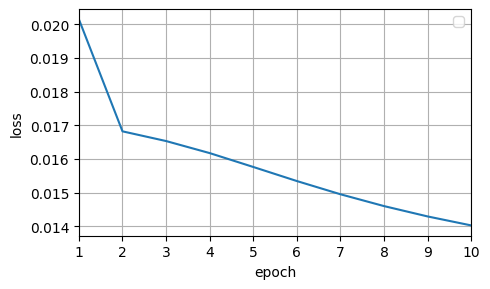

In [38]:
model = ch7.word2vecSkipGram(vocab_size=len(vocab), embed_size=64)
model = ch7.train_word2vec(model, data_iter, Epochs=10, verbose=1, lr=0.001)

现在，我们可以通过词嵌入的向量，利用余弦相似度来找到与目标词 `query_token` 最相似的 top K 个词，函数 `get_similar_tokens` 实现该功能

In [42]:
def get_similar_tokens(query_token : str, embed : tf.keras.layers.Embedding, vocab, top_k : int=3):
    """
    ## get_similar_tokens
        从词表中找出与查询词语义最相近的词
    
    Parameters
    ----------
    query_token : str
        查询目标词
    embed : tf.keras.layers.Embedding
        word2vec 模型的嵌入层
    vocab : Vocab
        词表
    top_k : int, default = 5
        返回最相近的 top_k 个词
    """
    # 获取 query_token 的词向量
    weights = embed.get_weights()[0] # 形状：(vocab_size, embed_size)
    query = weights[vocab[query_token]] # 形状：(embed_size,)
    # 计算余弦相似度，1e-9 做数值保护
    # weights @ query 形状：(vocab_size, 1)
    cos = (weights @ query[:, None])[:,0] / tf.sqrt(tf.reduce_sum(weights * weights, axis=1) * tf.reduce_sum(query * query) + 1e-9)
    
    # 通过 argsort 函数返回 top_k 个最大的元素的索引
    topk_tokens = tf.argsort(cos, axis=0, direction='DESCENDING')[:top_k+1].numpy().tolist()
    for i in topk_tokens:
        print('cosine sim = %.3f: %s' % (cos[i], vocab.idx_to_token[i]))

在使用嵌入层时，`SkipGram` 使用中心词表示，因此我们传递 `model.embed_v` 给查询函数 `get_similar_tokens`

In [43]:
ch7.get_similar_tokens('chip', model.embed_v, vocab, top_k=3)

cosine sim = 1.000: chip
cosine sim = 0.758: intel
cosine sim = 0.696: microprocessor
cosine sim = 0.645: fortunes


----

### **练习**